# Module: Loading HACC stellar catalog

> Importing the stellar catalogs compiled from HACC. This module may be edited for a different file reader if necessary. 

## The entries in the current stellar catalog are: 

### *[galaxy_tag, stellar_idx, metallicity, mass, age, x, y, z, vx, vy, vz]*

- galaxy_tag: Tags to galaxies given in the HACC datasets
- stellar idx: Unique ID for individual particles
- metallicity: Fraction of the metals in the stellar particles (Not rescaled by Zsun)
- mass: Mass of the stellar particle in Msun units
- age: Age of the stellar particles in 1/H0 units 
- [x, y, z]: Particle positions in Mpc/h units
- [vx, vy, vz]: Velocity of the particles

In [ ]:
#| default_exp load_sim_stellar_catalog

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import os
import matplotlib.pylab as plt

In [ ]:
#| export

GALS_DIR = '../hydro_colors/data/test_hacc_stellar_catalog/'
GALS_FILE = 'Gals_Z0.txt'

In [ ]:
#| export

Z_SOLAR_HACC = 0.012899 # Solar metallicity value in HACC Hydro
Z_SOLAR_PADOVA = 0.019 # Solar metallicity value in Padova 
H0 = 71.0 # Hubble Constant in HACC Hydro

In [ ]:
#| export

def _convert_metallicity(hacc_metallicity:np.array=None, # Metallicity values from HACC  
                         Z_solar:np.float32=Z_SOLAR_PADOVA, # Z_solar value from Padova
                        )-> np.array: # Metallicity array in Z/Z_solar units
    return hacc_metallicity/Z_solar

def _convert_age(hacc_age:np.array=None, #Age in 1/H0 units 
                 H0:np.float32=H0, # LastJourney H0 value
                )-> np.array: #Age in Gyr 
    '''
    (hacc_age is in 1/H0 units)
    H0 = (71 km/s/Mpc) x (1 Mpc/3.08 x 1e19 km) = 2.37 x 1e−18 1/s
    '''
    # https://www.e-education.psu.edu/astro801/content/l10_p5.html
    
    H0_per_sec = H0*(1/(3.08*1e19)) #seconds
    one_over_H0 = 1/H0_per_sec/(3.1536*1e16)
    age_hydro_gyr = hacc_age*one_over_H0
    
    return age_hydro_gyr

In [ ]:
#| export

def load_hacc_galaxy_data(fileIn:str=GALS_DIR+GALS_FILE, # Input galaxy catalog file from HACC hydro sim
                              Z_solar:np.float32=Z_SOLAR_PADOVA, #Solar metallicity
                              H0:np.float32=H0, # Hubble constant
                              ) -> tuple: # galaxy_tag, stellar_indices, metallicity, mass, age, x, y, z
    
    gal_tag, stellar_idx, metal, mass, age, x, y, z, vx, vy, vz = np.loadtxt(fileIn, 
                                                                 skiprows=1, 
                                                                 unpack=True)
    
    metal_z_solar = _convert_metallicity(metal, Z_solar)
    
    age_gyr = _convert_age(age, H0)
    
    return gal_tag, stellar_idx, metal_z_solar, mass, age_gyr, x, y, z, vx, vy, vz

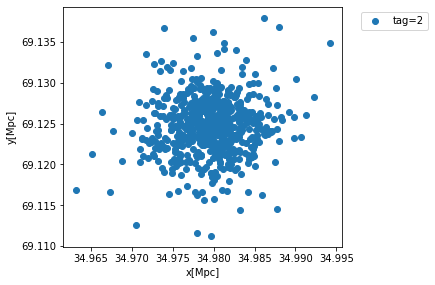

In [ ]:
#| hide

gal_tag, stellar_idx, metal, mass, age, x, y, z , vx, vy, vz = load_hacc_galaxy_data()

plt.figure(23, figsize =(5, 5))
# for gal_id in range(np.unique(gal_tag).shape[0]):
for gal_id in [2]:

    gal_tag_cond = np.where(gal_tag == np.unique(gal_tag)[gal_id])
    plt.scatter(x[gal_tag_cond], y[gal_tag_cond], label = 'tag=%d'%gal_id)
    
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('x[Mpc]')
plt.ylabel('y[Mpc]')
plt.show()

In [ ]:
#| hide 

import seaborn as sns
import pandas as pd

In [ ]:
#| hide 

def scatter_subset(x, y, hue, mask, **kws):
    sns.scatterplot(x=x[mask], y=y[mask], hue=hue[mask], **kws)

/home/nramachandra/anaconda3/envs/env_jax/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<Figure size 720x720 with 0 Axes>

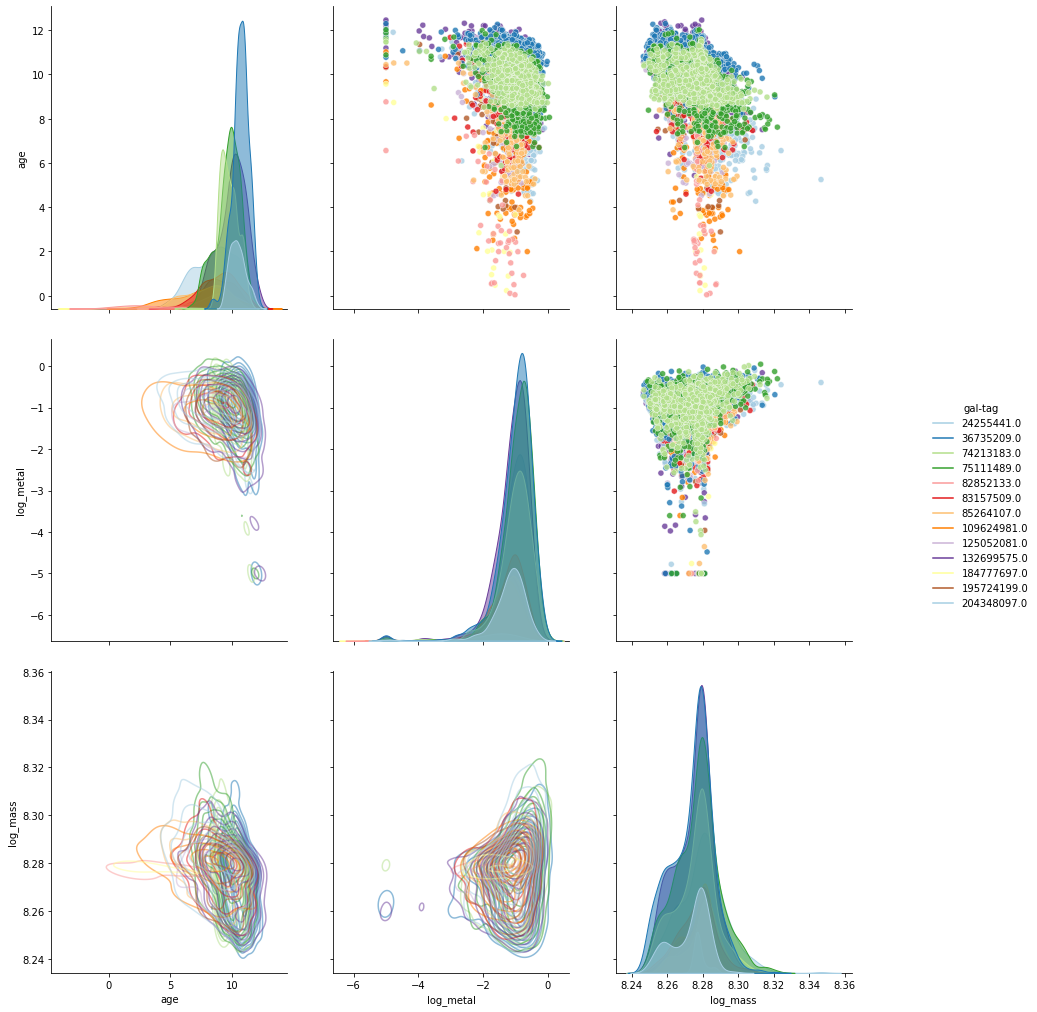

In [ ]:
#| hide 

plt.figure(figsize=(10, 10))

df = pd.DataFrame(np.array([gal_tag, age, np.log10(metal + 1e-5), np.log10(mass)]).T, columns=['gal-tag', 'age','log_metal','log_mass'])
df1 = pd.DataFrame(np.array([age[gal_tag_cond], np.log10(metal + 1e-10)[gal_tag_cond], np.log10(mass)[gal_tag_cond]]).T, columns=['age','log_metal','log_mass'])


df_all = pd.concat([df.assign(dataset='all'), df1.assign(dataset='tag-select')])


g = sns.PairGrid(df, hue="gal-tag", palette = "Paired", diag_sharey=False)
# g.map_lower(scatter_subset, mask=df["gal-tag"] == np.unique(gal_tag)[0])
g.map_upper(scatter_subset, mask=df["gal-tag"] != 0, alpha=0.8)
g.map_lower(sns.kdeplot, alpha=0.5, levels=10, fill=False)
g.map_diag(sns.kdeplot, fill=True, legend=False, warn_singular=False, alpha=0.5)
g.add_legend()
g.fig.set_size_inches(15,15)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()